### Imports

In [1]:
## Standard Imports
from IPython.display import display
import numpy as np
import pandas as pd
import pickle
import time
import datetime
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib as mpl
from sklearn import metrics
from sklearn import linear_model as lm
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import partial_dependence
from joblib import Parallel, delayed
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from matplotlib.collections import PolyCollection
import math


# Import Custom Utilities
import thesis_utils as utils
import analysis_utils as au

# Master Params
FIRST_TRADE_STRINGS = [f'{year}-01-01' for year in range(1993, 2023)]
KS = [5, 10, 50, 100]
NUM_TREES = 10
MAX_FEATURES = 6
MAX_DEPTH = 20
LAGS = np.concatenate((np.arange(1,21), (np.arange(2,13) * 20)))
TRAIN_DAYS = 504 
TRADE_DAYS = 252
T_COST = 0.001 # half-turn t-cost (need to scale returns if we are doing other analysis)

# Path for source files
# VERSION = '3'
# DATA_PATHNAME = f'Adroit_results_v{VERSION}'
RESULTS_PATHNAME = f'Analysis_PDP'
# RESULTS_PATHNAME = f'Analysis_PDP_3day'


# combine vix + ff
extra_factors_list = ['VIX', 'MKT', 'SMB', 'HML', 'RMW', 'CMA']

# Industry list
ind_names_list = ['IND_BusEq', 'IND_Chems', 'IND_Durbl', 'IND_Enrgy', 'IND_Fin', 'IND_Hlth', 'IND_Manuf', 'IND_NoDur', 'IND_Other', 'IND_Shops', 'IND_Telcm', 'IND_Utils']

# Labels
lag_labels = [f"R({i})" for i in LAGS] # Get lag labelsnum preds, based on period lag
labels_extra = lag_labels + extra_factors_list + ind_names_list


period_start = pd.to_datetime('1993-01-01')
period_end = pd.to_datetime('2022-12-31')

# styles
# plt.style.use('bmh')
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams["legend.facecolor"] = 'white'
mpl.rcParams["legend.frameon"] = True
mpl.rcParams["legend.framealpha"] = 0.8
mpl.rcParams['lines.linewidth'] = 2


mpl.rcParams['font.family'] = 'Latin Modern Math'
mpl.rcParams['font.size'] = 12
# mpl.rcParams['font.family'] = 'CMU Serif'
mpl.rc('axes', unicode_minus=False)

pdp_dict = pickle.load(open(f'pdps_v3.p', 'rb'))
# pdp_dict = pickle.load(open(f'pdps_v3day2.p', 'rb'))
years = [f'{year}' for year in range(1993, 2023)]




### PDP 2d

In [ ]:
# PDP for all 30 simulation years
def pdp_30y(feat):
    year1 = 1993
    fig, axs = plt.subplots(6, 5, figsize=(10,12), sharey='row')
    for i, ax in enumerate(axs.flatten()):
        year = f"{year1+i}"
        x = pdp_dict[year]['1D'][feat][1][0]
        y = pdp_dict[year]['1D'][feat][0][0]
        if i % 5 == 0:
            ax.set_ylabel('Target Response')
        if i >= (6-1) * 5:
            ax.set_xlabel(feat)
        ax.set_title(year)
        ax.plot(x,y)
        ax.tick_params(axis='x', labelrotation = 30)
    fig.suptitle(f'Partial Dependence on {feat}', fontsize='x-large')
    fig.tight_layout()
    plt.savefig(f'{RESULTS_PATHNAME}/PDP_{feat}.png', dpi=300)
    # plt.close() 
# for lab in labels_extra[:-12]:    
# pdp_30y('VIX')

def pdp_9y(year1, feat, n):
    v = []
    fig, axs = plt.subplots(n, n, figsize=(10,10), sharey=True, sharex=True)
    for i, ax in enumerate(axs.flatten()):
        year = f"{year1+i}"
        x = pdp_dict[year]['1D'][feat][1][0]
        y = pdp_dict[year]['1D'][feat][0][0]
        if i % n == 0:
            ax.set_ylabel('Target Response')
        if i >= (n-1) * n:
            ax.set_xlabel(feat)
        ax.set_title(year)
        ax.plot(x,y)
        v.append(np.std(y))
    fig.suptitle(f'Partial Dependence on {feat}', fontsize='x-large')
    fig.tight_layout()
    return v

v =pdp_9y(1993, 'R(2)', 5)
# plt.plot(v)

### PDP Panes

PDP panes

In [232]:

pdp_dict = pickle.load(open(f'pdps_v3.p', 'rb'))
years = [f'{year}' for year in range(1993, 2023)]

# Generates 3d plot of PDP plots
def generate_3d_pdp(feat, n_years=30, cm='viridis'):
    fig = plt.figure(figsize=(12,12), constrained_layout=True)
    ax = fig.add_subplot(projection='3d', computed_zorder=False)
    # ax = plt.axes(projection='3d')
    # z bounds
    z_lb = 1
    z_ub = -1
    for idx, year in enumerate(reversed(years[:n_years])):
        feature = pdp_dict[year]['1D'][feat][1][0]
        response = pdp_dict[year]['1D'][feat][0][0]
        z_ub = max(np.max(response), z_ub)
        z_lb = min(np.min(response), z_lb)

    def polygon_under_graph(x, y):
        return [(x[0], z_lb), *zip(x, y), (x[-1], z_lb)]
    
    x_l = 10000
    x_r = -10000
    verts = []
    z_range = np.arange(1,n_years+1) #(1, n_years+1)
    offset = 2
    facecolors = plt.colormaps[cm](np.linspace(0, 1, n_years+offset))[:-offset][::-1] # mpl.cm.turbo viridis_r
    for idx, year in enumerate(reversed(years[:n_years])):
        feature = pdp_dict[year]['1D'][feat][1][0]
        response = pdp_dict[year]['1D'][feat][0][0]
        # normalizer = lambda x: x/np.linalg.norm(x)# normalize
        # response = normalizer(response) + 0.5
        x_r = max(np.max(feature),x_r)
        x_l = min(np.min(feature),x_l)
        verts.append(polygon_under_graph(feature,response))
    verts = list(reversed(verts))
    # plot
    poly = PolyCollection(verts, facecolors=facecolors, alpha=.7, edgecolor='black', linewidth=1.3)
    ax.add_collection3d(poly, zs=z_range, zdir='y')
    ax.set_xlim(x_l, x_r)
    ax.set_zlim(z_lb, z_ub)
    ax.set_ylim(1,n_years+1)
    ax.set_box_aspect((1,2,0.75))
    yticks = np.append(z_range[1::5], 31)
    # print(yticks)
    ax.set_yticks(yticks)
    ax.set_yticklabels(np.append(years[0::5], '2022'))
    # ax.set_yticklabels([5, 10, 50, 100])    
    # ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    # ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    # ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.set_xlabel(f'\n {feat}')
    ax.set_ylabel('\nSimulation Year')
    ax.set_zlabel('\nTarget Response')
    ax.set_title(f'LR+F Model Partial Dependence on {feat} Over {n_years} Simulation Years', y=0.85, fontsize='x-large')

    ax.view_init(13, -70)



    fig.savefig(f'{RESULTS_PATHNAME}/3D/PDP_3D_{feat}.png', dpi=300, bbox_inches='tight') #  pad_inches=-.3
    # plt.close()
    # plt.show()


## 3d and time pdp

In [4]:
p1 = 'R(1)'
p2 = 'R(2)'

def nine_pdp_4d(p1, p2):
    pair = f'{p1} - {p2}'
    # get limits
    big = 100000000
    zmin = big
    zmax = -big
    xmin = big
    xmax = -big
    ymin = big
    ymax = -big

    # plot limits
    for year in years:
        res = pdp_dict[f'{year}']['2D'][pair]
        x = res["values"][0]
        y = res["values"][1]
        z = res['average'][0]
        zmin = min(zmin, np.min(z))
        zmax = max(zmax, np.max(z))
        xmin = min(xmin, np.min(x))
        xmax = max(xmax, np.max(x))
        ymin = min(ymin, np.min(y))
        ymax = max(ymax, np.max(y))

    yrs = years[::2]
    # yrs = years
    # yrs = [1993, 2008, 2015, 2022]
    fig = plt.figure(figsize=(15,14), constrained_layout=True) #, 
    fig.suptitle(f'LR+F Model Partial Dependence on {p1} and {p2} Over Time', y=1, fontsize='x-large')
    for i in range(9):
        year = yrs[i]
        res = pdp_dict[f'{year}']['2D'][pair]  
        XX, YY = np.meshgrid(res["values"][0], res["values"][1])
        Z = res['average'][0].T
        ax = fig.add_subplot(331+i,projection="3d")
        ax.set_zlim3d(zmin, zmax)
        ax.set_xlim3d(xmin, xmax)
        ax.set_ylim3d(ymin, ymax)
        fig.add_axes(ax)
        ax.set_xlabel(f'\n{p1}')
        ax.set_title(f'{year}', y=0.93)
        # ax.set_title(f'{year}', fontsize='large')
        ax.set_ylabel(f'\n{p2}')
        # ax.set_zlabel('\nTarget Response')
        ax.set_box_aspect((1,1,0.5))
        ax.view_init(20, -60)
        # ax.set_box_aspect(aspect=None, zoom=0.9)
        surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.viridis, edgecolor="k",linewidth=0.5)
        # for spine in ax.spines.values():
    # fig.tight_layout()

    fig.savefig(f'{RESULTS_PATHNAME}/9grid/PDP_x9_{pair}.png', dpi=300, bbox_inches='tight') 
    plt.close()

In [5]:
keys = pdp_dict[f'1993']['2D'].keys()
splits = [x.split(' - ') for x in keys]
splits
for p in splits:
    nine_pdp_4d(p[0], p[1])

PDP Demo

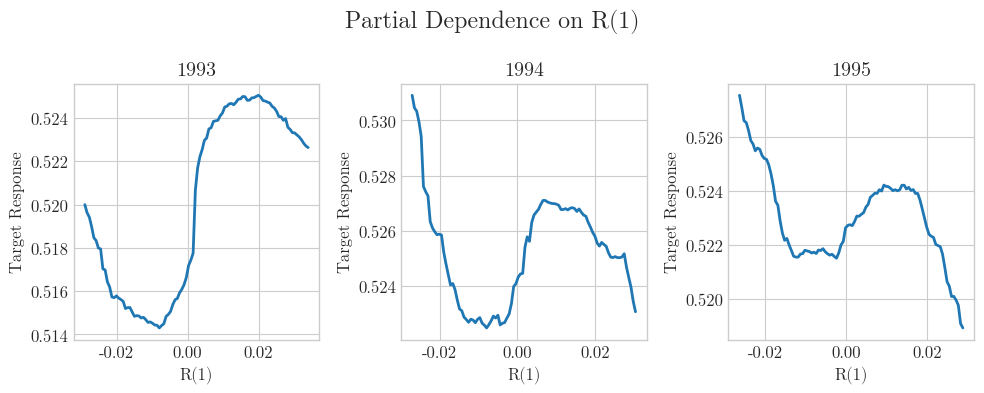

In [225]:
def pdp_3y(year1, feat):
    fig, ax = plt.subplots(1, 3, figsize=(10,4))
    for i in range(3):
        year = f"{year1+i}"
        x = pdp_dict[year]['1D'][feat][1][0]
        y = pdp_dict[year]['1D'][feat][0][0]
        ax[i].set_ylabel('Target Response')
        ax[i].set_xlabel(feat)
        ax[i].set_title(year)
        ax[i].plot(x,y)
    fig.suptitle(f'Partial Dependence on {feat}', fontsize='x-large')
    fig.tight_layout()
    fig.savefig(f'{RESULTS_PATHNAME}/PDP_3x_r1.png', dpi=300, bbox_inches='tight') 

pdp_3y(1993, 'R(1)')

